## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the TM5-4DVar Isotopic CH₄ Inverse Fluxes Data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

Surface methane (CH₄) emissions are derived from atmospheric measurements of methane and its ¹³C carbon isotope content. Different sources of methane contain different ratios of the two stable isotopologues, ¹²CH₄ and ¹³CH₄. This makes normally indistinguishable collocated sources of methane, say from agriculture and oil and gas exploration, distinguishable. The National Oceanic and Atmospheric Administration (NOAA) collects whole air samples from its global cooperative network of flasks (https://gml.noaa.gov/ccgg/about.html), which are then analyzed for methane and other trace gasses. A subset of those flasks are also analyzed for ¹³C of methane in collaboration with the Institute of Arctic and Alpine Research at the University of Colorado Boulder. Scientists at the National Aeronautics and Space Administration (NASA) and NOAA used those measurements of methane and ¹³C of methane in conjunction with a model of atmospheric circulation to estimate emissions of methane separated by three source types, microbial, fossil and pyrogenic.

## Installing the required libraries
Please run the cell below to install the libraries required to run this notebook.

## Querying the STAC API

In [1]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

# Please use the collection name similar to the one used in STAC collection.
# Name of the collection for TM5 CH₄ inverse flux dataset. 
collection_name = "tm54dvar-ch4flux-monthgrid-v1"

In [3]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'tm54dvar-ch4flux-monthgrid-v1',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1'}],
 'title': 'TM5-4DVar Isotopic CH4 Inverse Fluxes',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['1999-01-01T00:00:00+00:00',
     '2016-12-31T00:00:00+00:00']]}},
 'license': 'CC-BY-4.0',
 'keywords': None,
 'providers': None,
 'summaries': {'datetime': ['1999-01-01T00:00:00Z', '2016-12-31T00:00:00Z']},
 'description': 'Global, monthly 1 degree resolution methane emission estimates from microbial, f

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 1999 to December 2016. By looking at the `dashboard:time density`, we observe that the data is periodic with monthly time density.

In [4]:
def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)

        if not response.ok:
            print("error getting items")
            exit()

        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]

        if not next:
            break
        items_url = next[0]["href"]

    return count

In [5]:
# Check total number of items available
number_of_items = get_item_count(collection_name)
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]
print(f"Found {len(items)} items")

Found 216 items


In [6]:
# Examining the first item in the collection
items[0]

{'id': 'tm54dvar-ch4flux-monthgrid-v1-201612',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1/items/tm54dvar-ch4flux-monthgrid-v1-201612'}],
 'assets': {'total': {'href': 's3://ghgc-data-store/tm54dvar-ch4flux-monthgrid-v1/methane_emis_total_201612.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Total CH4 Emission',
   'proj:bbox': [-180.0, -90.0, 180.0, 90.0],
   'proj:epsg': 4326.0,
   'proj:shape

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in CH₄ flux Levels Using the Raster API

In this notebook, we will explore the global changes of CH₄ flux over time in urban regions. We will visualize the outputs on a map using `folium.`

In [7]:
# to access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"][:10]: item for item in items} 
asset_name = "fossil" #fossil fuel

In [8]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for 2020 and again for 2019, so that we can visualize each event independently.

In [9]:
color_map = "purd"
co2_flux_1 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2016-12-01']['collection']}&item={items['2016-12-01']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
co2_flux_1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=tm54dvar-ch4flux-monthgrid-v1&item=tm54dvar-ch4flux-monthgrid-v1-201612&assets=fossil&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0.0%2C202.8189294183266'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [10]:
co2_flux_2 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['1999-12-01']['collection']}&item={items['1999-12-01']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
co2_flux_2

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=tm54dvar-ch4flux-monthgrid-v1&item=tm54dvar-ch4flux-monthgrid-v1-199912&assets=fossil&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0.0%2C202.8189294183266'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Visualizing CH₄ flux Emissions from Fossil Fuel

In [11]:
# We'll import folium to map and folium.plugins to allow mapping side-by-side
import folium
import folium.plugins

# Set initial zoom and center of map for CO₂ Layer
# Centre of map [latitude,longitude]
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)


map_layer_2016 = TileLayer(
    tiles=co2_flux_1["tiles"][0],
    attr="GHG",
    opacity=0.8,
)
map_layer_2016.add_to(map_.m1)

map_layer_1999 = TileLayer(
    tiles=co2_flux_2["tiles"][0],
    attr="GHG",
    opacity=0.8,
)
map_layer_1999.add_to(map_.m2)

# visualising the map
map_



# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [12]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [13]:
# We'll plug in the coordinates for a location
# central to the study area and a reasonable zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6,
)

folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)
aoi_map

In [14]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Found {len(items)} items")

Found 216 items


In [15]:
# Explore the first item
items[0]

{'id': 'tm54dvar-ch4flux-monthgrid-v1-201612',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1/items/tm54dvar-ch4flux-monthgrid-v1-201612'}],
 'assets': {'total': {'href': 's3://ghgc-data-store/tm54dvar-ch4flux-monthgrid-v1/methane_emis_total_201612.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Total CH4 Emission',
   'proj:bbox': [-180.0, -90.0, 180.0, 90.0],
   'proj:epsg': 4326.0,
   'proj:shape

In [16]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    print(result)
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"][:10],
    }

In [17]:
for item in items:
    print(item["properties"]["start_datetime"][:10])
    break

2016-12-01


With the function above we can generate the statistics for the AOI.

In [18]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]]}, 'properties': {'statistics': {'b1': {'min': 0.0464402866499578, 'max': 49.61378870603235, 'mean': 9.039553150168388, 'count': 36.0, 'sum': 325.42391340606196, 'std': 11.97160706711745, 'median': 4.45260464610365, 'majority': 0.0464402866499578, 'minority': 0.0464402866499578, 'unique': 36.0, 'histogram': [[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0], [0.0464402866499578, 5.003175128588197, 9.959909970526436, 14.916644812464675, 19.873379654402914, 24.830114496341153, 29.786849338279392, 34.74358418021763, 39.700319022155874, 44.65705386409412, 49.61378870603235]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 36.0, 'percentile_2': 0.08155765896762883, 'percentile_98': 45.348544433662454}}}}
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0

In [19]:
stats[0]

{'statistics': {'b1': {'min': 0.0464402866499578,
   'max': 49.61378870603235,
   'mean': 9.039553150168388,
   'count': 36.0,
   'sum': 325.42391340606196,
   'std': 11.97160706711745,
   'median': 4.45260464610365,
   'majority': 0.0464402866499578,
   'minority': 0.0464402866499578,
   'unique': 36.0,
   'histogram': [[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0],
    [0.0464402866499578,
     5.003175128588197,
     9.959909970526436,
     14.916644812464675,
     19.873379654402914,
     24.830114496341153,
     29.786849338279392,
     34.74358418021763,
     39.700319022155874,
     44.65705386409412,
     49.61378870603235]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 36.0,
   'percentile_2': 0.08155765896762883,
   'percentile_98': 45.348544433662454}},
 'datetime': '2016-12-01'}

In [20]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2016-12-01,0.04644,49.613789,9.039553,36.0,325.423913,11.971607,4.452605,0.04644,0.04644,36.0,"[[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,0.081558,45.348544,2016-12-01
1,2016-11-01,0.04644,49.613789,9.039553,36.0,325.423913,11.971607,4.452605,0.04644,0.04644,36.0,"[[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,0.081558,45.348544,2016-11-01
2,2016-10-01,0.04644,49.613789,9.039553,36.0,325.423913,11.971607,4.452605,0.04644,0.04644,36.0,"[[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,0.081558,45.348544,2016-10-01
3,2016-09-01,0.04644,49.613789,9.039553,36.0,325.423913,11.971607,4.452605,0.04644,0.04644,36.0,"[[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,0.081558,45.348544,2016-09-01
4,2016-08-01,0.04644,49.613789,9.039553,36.0,325.423913,11.971607,4.452605,0.04644,0.04644,36.0,"[[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,0.081558,45.348544,2016-08-01


## Visualizing the Data as a Time Series
We can now explore the fossil fuel emission time series (January 1999 -December 2016) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'CH4 emission Values for Texas, Dallas (2015-2020)')

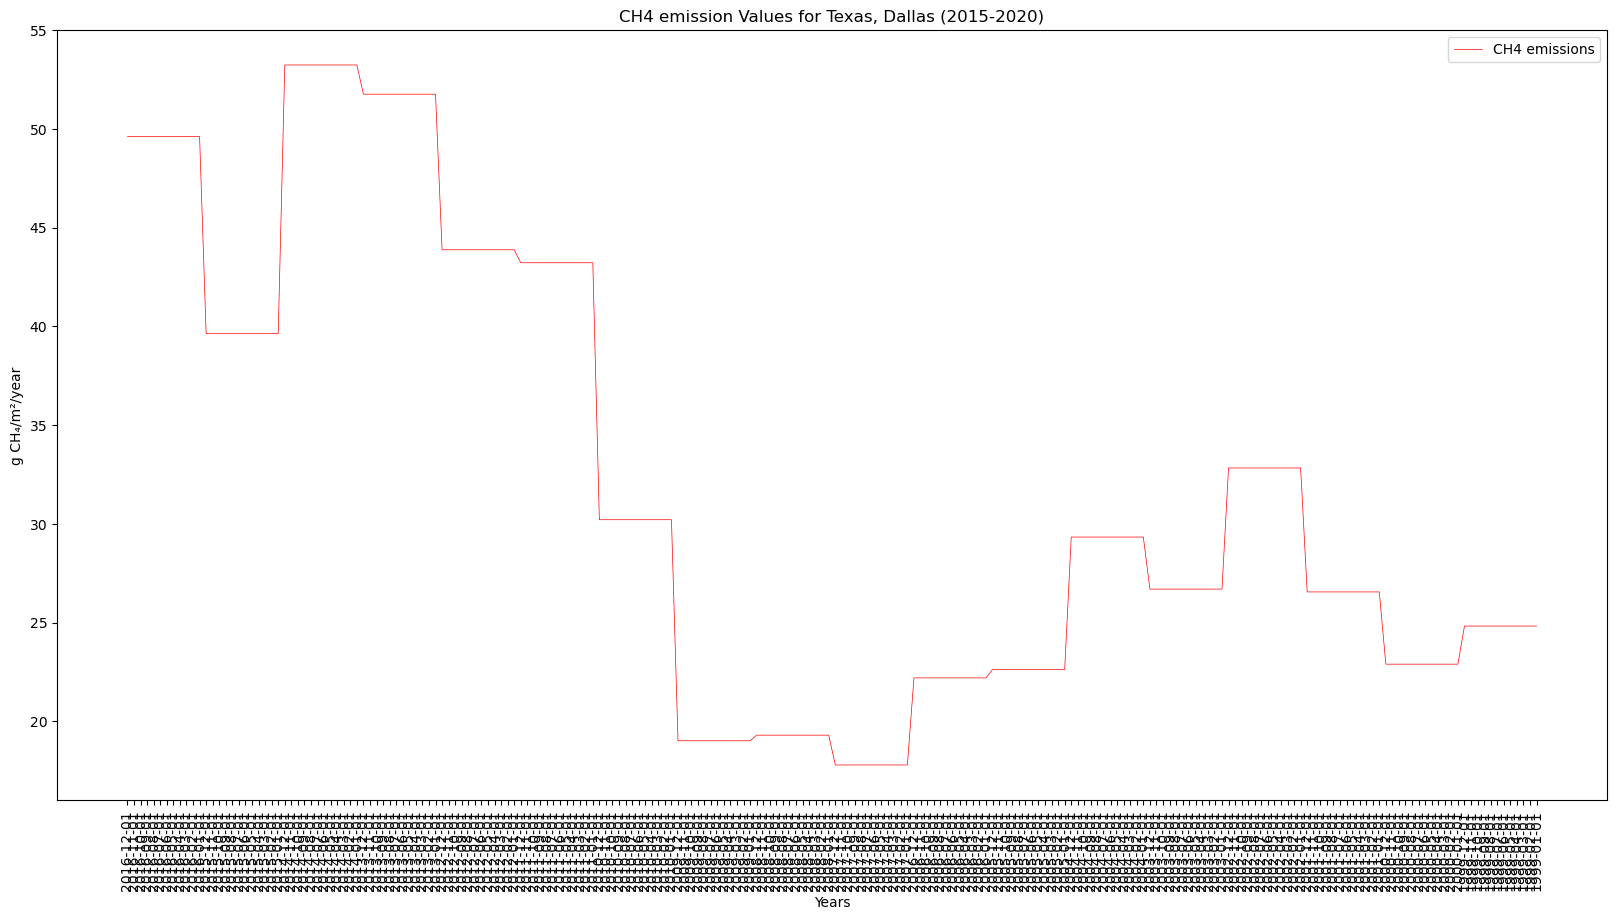

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["datetime"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="CH4 emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("g CH₄/m²/year")
plt.xticks(rotation = 90)
plt.title("CH4 emission Values for Texas, Dallas (2015-2020)")

In [22]:
print(items[2]["properties"]["start_datetime"])

2016-10-01T00:00:00+00:00


In [23]:
co2_flux_3 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
co2_flux_3

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=tm54dvar-ch4flux-monthgrid-v1&item=tm54dvar-ch4flux-monthgrid-v1-201610&assets=fossil&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0.0%2C202.8189294183266'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [24]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6.8,
)

map_layer = TileLayer(
    tiles=co2_flux_3["tiles"][0],
    attr="GHG", opacity = 0.7
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for TM5-4DVar Isotopic CH₄ Inverse Fluxes dataset.